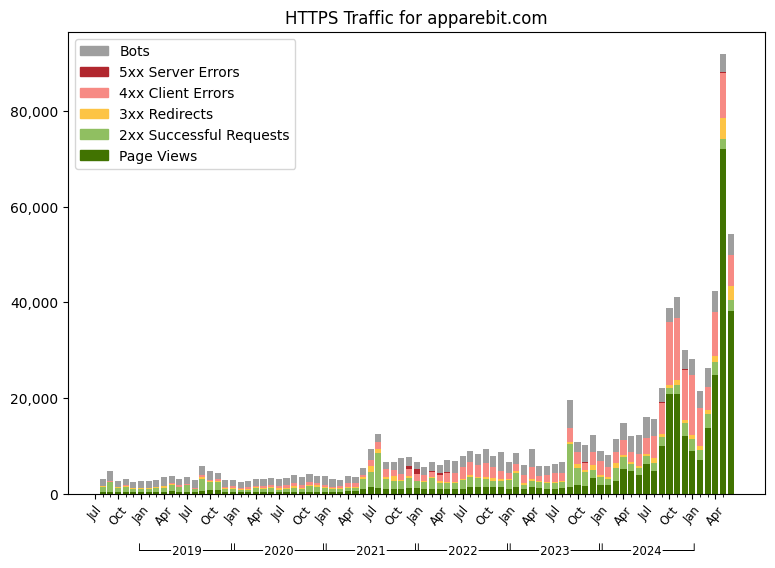

In [1]:
# Import modules. Ingest, validate, and summarize logs.
import konsole
konsole.config(level=konsole.WARNING)

from http import HTTPStatus
from IPython.display import display, HTML
import pandas as pd
import analog
from analog.label import APPAREBIT_COOL_PATHS

frame = analog.latest(root = "data")
analog.validate(frame)
summary = analog.summarize(frame)

section_number = 0
def sec() -> int:
    global section_number
    section_number += 1
    return section_number

display(HTML(f"<h2>{sec()}. Traffic Summary</h2>"))
analog.plot_monthly_summary(summary)
None

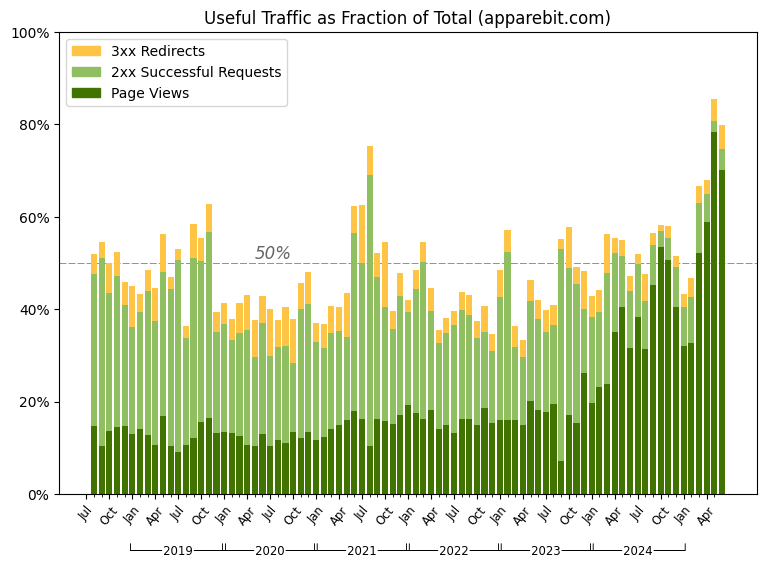

In [2]:
# Plot fraction of useful traffic
analog.plot_monthly_percentage(summary)
None

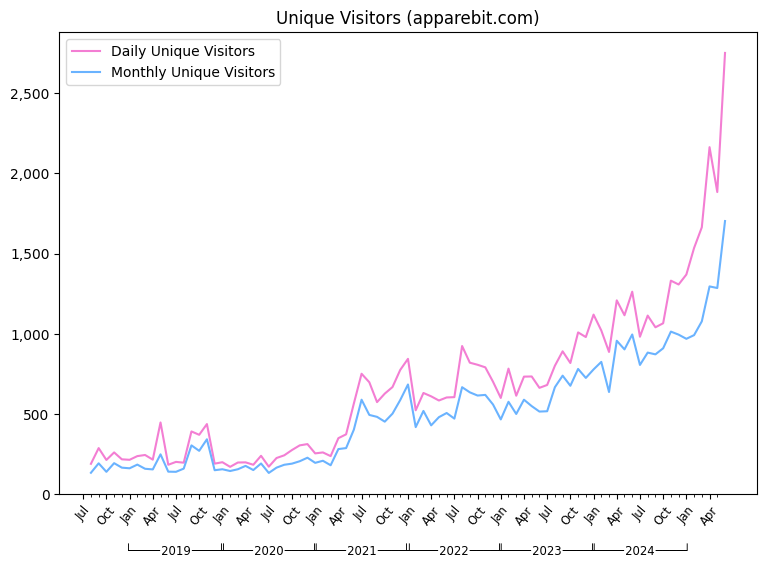

In [3]:
display(HTML(f"<h2>{sec()}. Unique Visitors"))
analog.plot_visitors(summary)
None

In [4]:
# Validate font license limits
max_views = summary.data["page_views"].max()

txt = f"<hr><h2>{sec()}. Font Licensing</h2>\n<p>"
txt += "✅" if max_views <= 50_000 else "❌"
txt += f" The <strong>maximum of monthly page views is {max_views:,}</strong>, which is "
if max_views > 50_000:
    txt += "<strong>not</strong> "
txt += "below Bely's license limit of 50,000.\n<p>"

max_visitors = summary.data["daily_visitors"].max()

txt += "✅" if max_visitors <= 15_000 else "❌"
txt += f" The <strong>maximum of monthly visitors is {max_visitors:,}</strong>, which is "
if max_visitors > 15_000:
    txt += "<strong>not</strong>"
txt += "below Bild's license limit of 15,000.\n<p>The monthly visitors are computed "
txt += "based on a heuristic that is also <a "
txt += "href='https://plausible.io/data-policy#how-we-count-unique-users-without-cookies'>used "
txt += "by Plausible analytics</a>. It counts unique tags computed by concatenating "
txt += "the date, the client IP address, and the user agent for non-bot page views."

display(HTML(txt))

In [5]:
# Page rank
def page_rank(label: str, data):
    df = (
        data
        .only.successful()
        .only.GET()
        .only.markup()
        .only.one_of("cool_path", *APPAREBIT_COOL_PATHS)
        .value_counts("cool_path")
        .data
        .reset_index()
    )

    df.columns = pd.MultiIndex.from_arrays([[label, label], df.columns])
    return df

data = analog.analyze(frame)

display(HTML(f"<hr><h2>{sec()}. April 2025 as Outlier</h2>"))

that_month = data.over.month_in_year(2025, 4).only.humans()
top10_pages = page_rank("april2025", that_month).head(10)
top_page_views = top10_pages.iloc[0, 1]
top10_agents = that_month.value_counts("user_agent").data.head(10)
top10_addresses = that_month.value_counts("client_address").data.head(10)
address10_views = top10_addresses.sum()

display(HTML(
    f"""
    <p>The following three tables show the top 10 pages, user agents, and IP
    addresses:
    <ul>
    <li>Pages have a clear outlier: I Feel Love with {top_page_views:,} views.
    <li>User agents seem ok.
    <li>IP addresses reveal abuse: {address10_views:,} views
    or {address10_views / top_page_views * 100:,.1f}% of all views.
    </ul>
    <p>The same IP address accessing the same page thousands of times in
    a month is not acceptable by any standard, human or bot. That comes
    awfully close to a denial of service attack.
    """
))

display(top10_pages.style.format(thousands=","))
display(top10_agents.to_frame().style.format(thousands=","))
display(top10_addresses.to_frame().style.format(thousands=","))


,count
user_agent,
"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36","2,151"
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36","2,070"
"Mozilla/5.0 (iPhone; CPU iPhone OS 13_2_3 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.3 Mobile/15E148 Safari/604.1","1,078"
"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36",505
"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",473
"Mozlila/5.0 (Linux; Android 7.0; SM-G892A Bulid/NRD90M; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/60.0.3112.107 Moblie Safari/537.36",378
Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/6.0),267
"Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.3.1 Mobile/15E148 Safari/604.1",239
"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36",235


,count
client_address,
13.94.89.4,"5,550"
52.184.145.227,"2,919"
13.94.89.90,"2,736"
40.69.216.16,"2,473"
52.169.144.138,"2,145"
52.167.133.1,"2,106"
172.190.142.176,"1,666"
13.90.159.79,"1,661"
52.164.243.23,"1,439"


In [6]:

df = pd.concat([
    page_rank("last_month", data.over.last_month().only.humans()),
    page_rank("last_year", data.over.last_year().only.humans()),
    page_rank("all_time", data.only.humans()),
], axis=1)

display(HTML(f"<hr><h2>{sec()}. Non-Bot Page Rankings</h2>"))
display(df.style.format(thousands=","))

df = pd.concat([
    page_rank("last_month", data.over.last_month().only.bots()),
    page_rank("last_year", data.over.last_year().only.bots()),
    page_rank("all_time", data.only.bots()),
], axis=1)

display(HTML(f"<hr><h2>{sec()}. Bot Page Rankings</h2>"))
display(df.style.format(thousands=","))


In [7]:
# Client errors

status_ranking = []
path_ranking = []

def analyze_errors(label: str, data):
    data = data.only.humans().only.client_error()

    df = data.value_counts("status").data.to_frame().reset_index()
    df.insert(1, column="phrase", value=[HTTPStatus(s).phrase for s in df["status"]])
    df.columns = pd.MultiIndex.from_arrays([[label, label, label], df.columns])
    status_ranking.append(df)

    df = data.value_counts("path").data.to_frame().reset_index().head(20)
    df.columns = pd.MultiIndex.from_arrays([[label, label], df.columns])
    path_ranking.append(df)

data = analog.analyze(frame)
analyze_errors("last_month", data.over.last_month())
analyze_errors("last_year", data.over.last_year())
analyze_errors("all_time", data)

display(HTML(f"<hr><h2>{sec()}. Non-Bot Client Errors By Status Code and Path</h2>"))
display(pd.concat(status_ranking, axis=1).style.format(precision=0, thousands=",", na_rep=""))
display(pd.concat(path_ranking, axis=1).style.format(thousands=","))

In [8]:
# I Feel Love
attempted = (
    data
    .only.humans()
    .only.GET()
    .only.markup()
    .only.equals("path", "/blog/2019/i-feel-love")
)
successful = attempted.only.successful()

total = attempted.requests()
w00t = successful.requests()
w00t_pct = w00t / total * 100
addr = len(attempted.unique_values("client_address").data)

txt = f"<hr><h2>{sec()}. I Feel Love</h2><ul>"
txt += f"<li>There were {total:,} requests for the page."
txt += f"<li>{w00t:,} ({w00t_pct:.1f}%) requests were successful."
txt += f"<li>{addr:,} clients issued {total/addr:.1f} requests each (on average)."

referrers = attempted.value_counts("referrer")
refer = referrers.data.sum()

txt += f"<li>{refer:,} ({refer/total*100:.1f}%) requests have a referrer."
txt += "</ul>\n<br><br><h3>Top 30 Referrers</h3>"

display(HTML(txt))
referrers.show(rows=30).done()

# df = pd.DataFrame({"client_address": feel_love.value_counts("client_address").data.head(10).index}).merge(feel_love.data, how="left")
# df["client_city"].drop_duplicates()

,count
referrer,
http://obscenely.gay,"1,404"
http://www.obscenely.gay,"1,045"
http://obscenely.gay/wp-login.php,498
www.google.com,490
http://www.google.com/url?url=apparebit.com&yahoo.com,348
http://obscenely.gay/,333
http://google.com/,317
https://apparebit.com/blog/2019/i-feel-love,300
https://obscenely.gay/,291
